In [2]:
import numpy as np
import xarray as xr
import xmitgcm as xm

import eddytools as et

In [3]:
# paths
datapath = r"/scratch/snx3000/aleroqua/geneva_200m_4months/run_01"
gridpath = datapath
outputpath = "./workspace/nencioli/"
ref_date = "2023-12-01 0:0:0"

In [4]:
# load data
dt = 4.0
data = xm.open_mdsdataset(
    datapath,
    delta_t=dt,
    ignore_unknown_vars=True,
    grid_dir=gridpath,
    geometry="cartesian",
    calendar="standard",
    ref_date=ref_date,
    prefix="3Dsnaps",
    endian="<",
)

In [5]:
str_start_time = "2023-12-24T00:30:00.000000000"
str_end_time = "2023-12-25T00:30:00.000000000"

start_date_analysis = np.datetime64(str_start_time)
end_date_analysis = np.datetime64(str_end_time)

data_cropped = data.sel(time=slice(start_date_analysis, end_date_analysis))
data_cropped = data_cropped.isel(Z=[0, 1])

In [6]:
data_cropped["SPEED"] = np.sqrt(data_cropped["UVEL"] ** 2 + data_cropped["VVEL"] ** 2)

In [7]:
VVEL_new = (
    data_cropped["VVEL"]
    .rename({"YG": "lat", "XC": "lon", "Z": "Depth"})
    .assign_coords(lat=data_cropped["YC"].values)
)
UVEL_new = (
    data_cropped["UVEL"]
    .rename({"XG": "lon", "YC": "lat", "Z": "Depth"})
    .assign_coords(lon=data_cropped["XC"].values)
)

data_aligned = xr.Dataset(
    {
        "UVEL": UVEL_new,
        "VVEL": VVEL_new,
    },
    coords={
        "lon": data_cropped["XC"].values,
        "lat": data_cropped["YC"].values,
        "Depth": data_cropped["Z"].values,
    },
)

data_aligned["SPEED"] = np.sqrt(data_aligned["UVEL"] ** 2 + data_aligned["VVEL"] ** 2)

In [8]:
# Specify parameters for eddy detection
detection_parameters = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": 100,  # minimum longitude of detection region
    "lon2": 65000,  # maximum longitude
    "lat1": 100,  # minimum latitude
    "lat2": 25000,  # maximum latitude
    "res": 10.0,  # resolution of the fields in km
    "min_dep": 250,  # minimum ocean depth where to look for eddies in m
    "Npix_min": 1000,  # minimum number of pixels (grid cells) to be considered as eddy
    "Npix_max": 5000,  # maximum number of pixels (grid cells)
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 10,
    "b": 2,
    "rad": 4,
}

In [9]:
et.detection.detect_UV(data_aligned, detection_parameters, "UVEL", "VVEL", "SPEED")

preparing data for eddy detection (masking and region extracting etc.)
step2
step3
step3.0
step3.1
step3.2
step3.3
step4
step5
step5
detection at time step  1  of  25
step5
step5
step5
detection at time step  4  of  25
step5
step5
step5
detection at time step  7  of  25
step5
step5
detection at time step  9  of  25
step5
step5
step5
detection at time step  12  of  25
step5
step5
step5
detection at time step  15  of  25
step5
step5
step5
detection at time step  18  of  25
step5
step5
detection at time step  20  of  25
step5
step5
step5
detection at time step  23  of  25
step5
step5


{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {}}

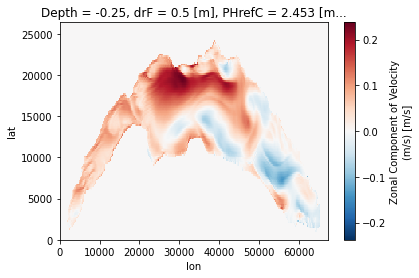

In [10]:
data_aligned["UVEL"].isel(time=-1, Depth=0).plot()